In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class denseBasic(nn.Module):
    def __init__(self,in_channels,growth_rate):
        super(denseBasic, self).__init__()
        self.layer=nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            # 手动规定 k=4
            nn.Conv2d(in_channels,growth_rate*4,kernel_size=(1,1)),
            nn.BatchNorm2d(growth_rate*4),
            nn.ReLU(),
            nn.Conv2d(growth_rate*4,growth_rate,kernel_size=(3,3),padding=1),
        )

    def forward(self,x):
        x=torch.cat((x,self.layer(x)),dim=1)
        return x


class denseBlock(nn.Module):
    def __init__(self,in_channels,growth_rate,num_layer):
        super(denseBlock, self).__init__()
        block=[]
        # 随着layer层数的增加，每增加一层，输入的特征图就增加一倍growth_rate
        for i in range(num_layer):
            block.append(denseBasic(in_channels,growth_rate))
            in_channels+=growth_rate
        self.denseblock=nn.Sequential(*block)

    def forward(self,x):
        return self.denseblock(x)

class transistion(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(transistion, self).__init__()
        self.mytransistion = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            # 默认设置为（3x3）,padding=1,stride = 1
            nn.Conv2d(in_channels,out_channels,kernel_size=(3,3),stride=1,padding=1)
        )

    def forward(self,x):
        x = self.mytransistion(x)
        return x


class denseNet(nn.Module):
    def __init__(self):
        super(denseNet, self).__init__()
        #处理input 3*32*32
        self.sovleinput = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=(7,7),stride=2,padding=3),
            nn.BatchNorm2d(32),#防止过拟合
            # 32*32*32
            nn.MaxPool2d(2),
            # 32*16*16
            nn.ReLU(),
        )
        self.denseblock1=denseBlock(32,32,6)
        #(32+32*6)*16*16
        self.transistion1=transistion(32+32*6,64)
        #64*8*8
        self.denseblock2=denseBlock(64,64,6)
        self.fc = nn.Sequential(
            #(64+64*6)*4*4*4
            nn.Linear((64+64*6)*4*4*4,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self,x):
        x = self.sovleinput(x)
        x=self.denseblock1(x)
        x=self.transistion1(x)
        x=self.denseblock2(x)
        x=x.reshape(x.shape[0],-1)
        #print(x.shape)
        x = self.fc(x)
        return x

net=denseNet()
print(net)
net = net.cuda()

denseNet(
  (sovleinput): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (denseblock1): denseBlock(
    (denseblock): Sequential(
      (0): denseBasic(
        (layer): Sequential(
          (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU()
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): denseBasic(
        (layer): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2):

Files already downloaded and verified
Files already downloaded and verified
torch.Size([4, 3, 32, 32])


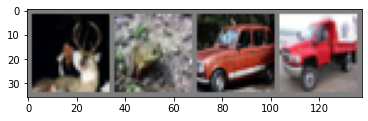

deer  frog  car   truck


In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#每次dataloader加载数据时：dataloader一次性创建num_worker个worker，
#（也可以说dataloader一次性创建num_worker个工作进程，worker也是普通的工作进程），
#并用batch_sampler将指定batch分配给指定worker，worker将它负责的batch加载进RAM
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
# show images
#make_grid的作用是将若干幅图像拼成一幅图像
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []
accuracys = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs=inputs.cuda()
        outputs = net(inputs)
        outputs=outputs.cuda()
        labels=labels.cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(i)
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            losses.append(running_loss / 2000)
            running_loss = 0.0
    # dev
    mycorrect = 0
    mytotal = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images= images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            outputs = outputs.cuda()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            mytotal += labels.size(0)
            mycorrect += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * mycorrect // mytotal} %')
    accuracys.append(100 * mycorrect // mytotal)
print('Finished Training')

[1,  2000] loss: 1.773
[1,  4000] loss: 1.534
[1,  6000] loss: 1.452
[1,  8000] loss: 1.389
[1, 10000] loss: 1.320
[1, 12000] loss: 1.309
Accuracy of the network on the 10000 test images: 56 %
[2,  2000] loss: 1.174
[2,  4000] loss: 1.190
[2,  6000] loss: 1.176
[2,  8000] loss: 1.187
[2, 10000] loss: 1.151
[2, 12000] loss: 1.122
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.986
[3,  4000] loss: 0.980
[3,  6000] loss: 1.019
[3,  8000] loss: 1.027
[3, 10000] loss: 1.009
[3, 12000] loss: 1.015
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 0.814
[4,  4000] loss: 0.826
[4,  6000] loss: 0.869
[4,  8000] loss: 0.899
[4, 10000] loss: 0.888
[4, 12000] loss: 0.895
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.688
[5,  4000] loss: 0.730
[5,  6000] loss: 0.750
[5,  8000] loss: 0.743
[5, 10000] loss: 0.791
[5, 12000] loss: 0.760
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.573
[6,  4000] l

Text(0.5, 1.0, 'Densenet loss')

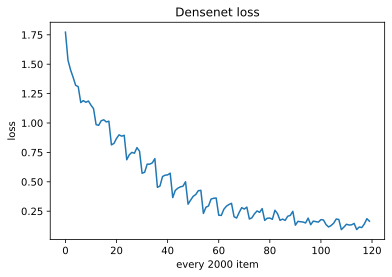

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'svg'
plt.figure()
plt.plot(losses)
plt.xlabel("every 2000 item")
plt.ylabel("loss")
plt.title("Densenet loss")

[56, 64, 65, 67, 69, 68, 68, 68, 69, 68, 70, 70, 70, 69, 68, 69, 70, 70, 71, 71]


Text(0.5, 1.0, 'Densenet accuracy')

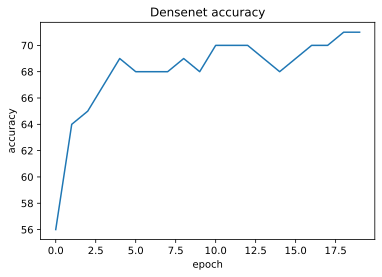

In [43]:
print(accuracys)
plt.plot(accuracys)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Densenet accuracy")